# Prediction of subscription for Orchestra--Modeling Part

Our task is to predict which previous patrons will purchase a subscription to the 2014-15 concert season.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif
from sklearn.decomposition import PCA
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

## Load data

In [3]:
acc=pd.read_csv('account.csv',encoding = 'latin' )

In [4]:
acc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19833 entries, 0 to 19832
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               19833 non-null  object 
 1   shipping.zip.code        264 non-null    object 
 2   billing.zip.code         16878 non-null  object 
 3   shipping.city            272 non-null    object 
 4   billing.city             17615 non-null  object 
 5   relationship             661 non-null    object 
 6   amount.donated.2013      19833 non-null  float64
 7   amount.donated.lifetime  19833 non-null  float64
 8   no.donations.lifetime    19833 non-null  int64  
 9   first.donated            5535 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.5+ MB


Drop columns with too much missing values.

In [5]:
acc.drop(['shipping.zip.code','shipping.city','relationship'],axis=1,inplace=True)

In [6]:
ticket=pd.read_csv('tickets_all.csv',encoding = 'latin')
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   account.id        2808 non-null   object 
 1   price.level       2600 non-null   object 
 2   no.seats          2808 non-null   int64  
 3   marketing.source  584 non-null    object 
 4   season            2808 non-null   object 
 5   location          2764 non-null   object 
 6   set               2786 non-null   float64
 7   multiple.tickets  2808 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 175.6+ KB


## Deal with missing data and combine data from different sources

In [7]:
ticket['marketing.source'].isnull().sum()/ticket.shape[0]

0.792022792022792

The percentage of missing data is too large to impute. Therefore, we can just drop this feature.

In [8]:
ticket.drop('marketing.source',axis=1,inplace=True)

In [9]:
data=acc.merge(ticket,how='left',on='account.id')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20592 entries, 0 to 20591
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               20592 non-null  object 
 1   billing.zip.code         17635 non-null  object 
 2   billing.city             18373 non-null  object 
 3   amount.donated.2013      20592 non-null  float64
 4   amount.donated.lifetime  20592 non-null  float64
 5   no.donations.lifetime    20592 non-null  int64  
 6   first.donated            5710 non-null   object 
 7   price.level              2600 non-null   object 
 8   no.seats                 2808 non-null   float64
 9   season                   2808 non-null   object 
 10  location                 2764 non-null   object 
 11  set                      2786 non-null   float64
 12  multiple.tickets         2808 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 2.2+ MB


In [11]:
sub=pd.read_csv('subscriptions.csv',encoding = 'latin')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28627 entries, 0 to 28626
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   account.id         28627 non-null  object 
 1   season             28627 non-null  object 
 2   package            28621 non-null  object 
 3   no.seats           28627 non-null  int64  
 4   location           28621 non-null  object 
 5   section            24084 non-null  object 
 6   price.level        25093 non-null  float64
 7   subscription_tier  28627 non-null  float64
 8   multiple.subs      28627 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.0+ MB


In [12]:
data=data.merge(sub,how='left',on='account.id',suffixes=('_t','_s'))               

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43599 entries, 0 to 43598
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               43599 non-null  object 
 1   billing.zip.code         40581 non-null  object 
 2   billing.city             41324 non-null  object 
 3   amount.donated.2013      43599 non-null  float64
 4   amount.donated.lifetime  43599 non-null  float64
 5   no.donations.lifetime    43599 non-null  int64  
 6   first.donated            26240 non-null  object 
 7   price.level_t            4429 non-null   object 
 8   no.seats_t               4869 non-null   float64
 9   season_t                 4869 non-null   object 
 10  location_t               4776 non-null   object 
 11  set                      4780 non-null   float64
 12  multiple.tickets         4869 non-null   object 
 13  season_s                 29497 non-null  object 
 14  package               

In [14]:
zipcode=pd.read_csv('zipcodes.csv',encoding = 'latin')
zipcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42522 entries, 0 to 42521
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Zipcode              42522 non-null  int64  
 1   ZipCodeType          42522 non-null  object 
 2   City                 42522 non-null  object 
 3   State                42522 non-null  object 
 4   LocationType         42522 non-null  object 
 5   Lat                  41874 non-null  float64
 6   Long                 41874 non-null  float64
 7   Location             42521 non-null  object 
 8   Decommisioned        42522 non-null  bool   
 9   TaxReturnsFiled      28879 non-null  float64
 10  EstimatedPopulation  28879 non-null  float64
 11  TotalWages           28844 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(5)
memory usage: 3.6+ MB


In [15]:
zipcode['Zipcode']=zipcode['Zipcode'].astype(str)

In [16]:
zipcode.isnull().sum()/zipcode.shape[0]

Zipcode                0.000000
ZipCodeType            0.000000
City                   0.000000
State                  0.000000
LocationType           0.000000
Lat                    0.015239
Long                   0.015239
Location               0.000024
Decommisioned          0.000000
TaxReturnsFiled        0.320846
EstimatedPopulation    0.320846
TotalWages             0.321669
dtype: float64

In [17]:
data=data.merge(zipcode,how='left',left_on='billing.zip.code',right_on='Zipcode')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43599 entries, 0 to 43598
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               43599 non-null  object 
 1   billing.zip.code         40581 non-null  object 
 2   billing.city             41324 non-null  object 
 3   amount.donated.2013      43599 non-null  float64
 4   amount.donated.lifetime  43599 non-null  float64
 5   no.donations.lifetime    43599 non-null  int64  
 6   first.donated            26240 non-null  object 
 7   price.level_t            4429 non-null   object 
 8   no.seats_t               4869 non-null   float64
 9   season_t                 4869 non-null   object 
 10  location_t               4776 non-null   object 
 11  set                      4780 non-null   float64
 12  multiple.tickets         4869 non-null   object 
 13  season_s                 29497 non-null  object 
 14  package               

In [19]:
concerts=pd.read_csv('concerts.csv',encoding = 'latin')
concerts=concerts.rename(columns={'ï»¿season':'season'})
concerts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   season        103 non-null    object
 1   concert.name  103 non-null    object
 2   set           103 non-null    int64 
 3   who           103 non-null    object
 4   what          103 non-null    object
 5   location      100 non-null    object
dtypes: int64(1), object(5)
memory usage: 5.0+ KB


In [20]:
data.info()                
             

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43599 entries, 0 to 43598
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               43599 non-null  object 
 1   billing.zip.code         40581 non-null  object 
 2   billing.city             41324 non-null  object 
 3   amount.donated.2013      43599 non-null  float64
 4   amount.donated.lifetime  43599 non-null  float64
 5   no.donations.lifetime    43599 non-null  int64  
 6   first.donated            26240 non-null  object 
 7   price.level_t            4429 non-null   object 
 8   no.seats_t               4869 non-null   float64
 9   season_t                 4869 non-null   object 
 10  location_t               4776 non-null   object 
 11  set                      4780 non-null   float64
 12  multiple.tickets         4869 non-null   object 
 13  season_s                 29497 non-null  object 
 14  package               

In [21]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,43589,43590,43591,43592,43593,43594,43595,43596,43597,43598
account.id,001i000000LhSrQ,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,001i000000LhyPD,...,001i0000017bU6I,001i0000018979H,001i00000189gLm,001i0000018BYAx,001i0000018BYWp,001i0000018BZTP,001i0000018BZTt,001i0000018BZUN,001i0000018BZUr,001i0000018Bbdd
billing.zip.code,94102,94303,94303,94303,94303,94303,94303,94303,94303,94303,...,95476,94044,94102,94116,94703,95014,94521,94552,94043,94556
billing.city,San Francisco,Palo Alto,Palo Alto,Palo Alto,Palo Alto,Palo Alto,Palo Alto,Palo Alto,Palo Alto,Palo Alto,...,Sonoma,Pacifica,San Francisco,San Francisco,Berkeley,Cupertino,Concord,castro valley,Mountain view,Moraga
amount.donated.2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amount.donated.lifetime,0.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
no.donations.lifetime,0,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
first.donated,NaN,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,1987-07-04 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price.level_t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
no.seats_t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season_t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data.isnull().sum()/data.shape[0]

account.id                 0.000000
billing.zip.code           0.069222
billing.city               0.052180
amount.donated.2013        0.000000
amount.donated.lifetime    0.000000
no.donations.lifetime      0.000000
first.donated              0.398151
price.level_t              0.898415
no.seats_t                 0.888323
season_t                   0.888323
location_t                 0.890456
set                        0.890364
multiple.tickets           0.888323
season_s                   0.323448
package                    0.323585
no.seats_s                 0.323448
location_s                 0.323585
section                    0.432556
price.level_s              0.407578
subscription_tier          0.323448
multiple.subs              0.323448
Zipcode                    0.098259
ZipCodeType                0.098259
City                       0.098259
State                      0.098259
LocationType               0.098259
Lat                        0.098420
Long                       0

In [23]:
data['no.seats_s']=data['no.seats_s'].fillna(data['no.seats_t'])
data['season_s']=data['season_s'].fillna(data['season_t'])
data['location_s']=data['location_s'].fillna(data['location_t'])
data['price.level_s']=data['price.level_s'].fillna(data['price.level_t'])


In [24]:
data.isnull().sum()/data.shape[0]

account.id                 0.000000
billing.zip.code           0.069222
billing.city               0.052180
amount.donated.2013        0.000000
amount.donated.lifetime    0.000000
no.donations.lifetime      0.000000
first.donated              0.398151
price.level_t              0.898415
no.seats_t                 0.888323
season_t                   0.888323
location_t                 0.890456
set                        0.890364
multiple.tickets           0.888323
season_s                   0.273263
package                    0.323585
no.seats_s                 0.273263
location_s                 0.274135
section                    0.432556
price.level_s              0.352829
subscription_tier          0.323448
multiple.subs              0.323448
Zipcode                    0.098259
ZipCodeType                0.098259
City                       0.098259
State                      0.098259
LocationType               0.098259
Lat                        0.098420
Long                       0

In [25]:
data['section'].unique()

array([nan, 'Orchestra', 'Balcony Front', 'Premium Orchestra',
       'Orchestra Front', 'Balcony', 'Dress Circle', 'Balcony Rear',
       'Orchestra Rear', 'Box', 'Boxes House Left', 'Gallery',
       'Boxes House Right', 'Santa Rosa', 'Floor'], dtype=object)

In [26]:
mis=data.isnull().sum()/data.shape[0]

We will check each feature whose missing value is less than 50%. If one feature's missing value is over 50% percent, then the missing value cannot be imputed accurately.

In [27]:
feat1=mis.loc[(mis<0.5)]
feat1=feat1.index.tolist()
data_1=data[feat1]
data_1.isnull().sum()/data_1.shape[0]

In [31]:
data_1['section']=data_1['section'].fillna('Undefined')

In [32]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43599 entries, 0 to 43598
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               43599 non-null  object 
 1   billing.zip.code         40581 non-null  object 
 2   billing.city             41324 non-null  object 
 3   amount.donated.2013      43599 non-null  float64
 4   amount.donated.lifetime  43599 non-null  float64
 5   no.donations.lifetime    43599 non-null  int64  
 6   first.donated            26240 non-null  object 
 7   season_s                 31685 non-null  object 
 8   package                  29491 non-null  object 
 9   no.seats_s               31685 non-null  float64
 10  location_s               31647 non-null  object 
 11  section                  43599 non-null  object 
 12  price.level_s            28216 non-null  object 
 13  subscription_tier        29497 non-null  float64
 14  multiple.subs         

In [33]:
data_1.isnull().sum()/data_1.shape[0]

account.id                 0.000000
billing.zip.code           0.069222
billing.city               0.052180
amount.donated.2013        0.000000
amount.donated.lifetime    0.000000
no.donations.lifetime      0.000000
first.donated              0.398151
season_s                   0.273263
package                    0.323585
no.seats_s                 0.273263
location_s                 0.274135
section                    0.000000
price.level_s              0.352829
subscription_tier          0.323448
multiple.subs              0.323448
Zipcode                    0.098259
ZipCodeType                0.098259
City                       0.098259
State                      0.098259
LocationType               0.098259
Lat                        0.098420
Long                       0.098420
Location                   0.098259
Decommisioned              0.098259
TaxReturnsFiled            0.103397
EstimatedPopulation        0.103397
TotalWages                 0.127274
dtype: float64

In [34]:
data_1.drop('first.donated',axis=1,inplace=True)

In [35]:
data_1.isnull().sum()/data_1.shape[0]

account.id                 0.000000
billing.zip.code           0.069222
billing.city               0.052180
amount.donated.2013        0.000000
amount.donated.lifetime    0.000000
no.donations.lifetime      0.000000
season_s                   0.273263
package                    0.323585
no.seats_s                 0.273263
location_s                 0.274135
section                    0.000000
price.level_s              0.352829
subscription_tier          0.323448
multiple.subs              0.323448
Zipcode                    0.098259
ZipCodeType                0.098259
City                       0.098259
State                      0.098259
LocationType               0.098259
Lat                        0.098420
Long                       0.098420
Location                   0.098259
Decommisioned              0.098259
TaxReturnsFiled            0.103397
EstimatedPopulation        0.103397
TotalWages                 0.127274
dtype: float64

In [36]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43599 entries, 0 to 43598
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               43599 non-null  object 
 1   billing.zip.code         40581 non-null  object 
 2   billing.city             41324 non-null  object 
 3   amount.donated.2013      43599 non-null  float64
 4   amount.donated.lifetime  43599 non-null  float64
 5   no.donations.lifetime    43599 non-null  int64  
 6   season_s                 31685 non-null  object 
 7   package                  29491 non-null  object 
 8   no.seats_s               31685 non-null  float64
 9   location_s               31647 non-null  object 
 10  section                  43599 non-null  object 
 11  price.level_s            28216 non-null  object 
 12  subscription_tier        29497 non-null  float64
 13  multiple.subs            29497 non-null  object 
 14  Zipcode               

In [37]:
data_1['no.seats_s']=data_1['no.seats_s'].astype(str)
data_1['subscription_tier']=data_1['subscription_tier'].astype(str)

In [38]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43599 entries, 0 to 43598
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               43599 non-null  object 
 1   billing.zip.code         40581 non-null  object 
 2   billing.city             41324 non-null  object 
 3   amount.donated.2013      43599 non-null  float64
 4   amount.donated.lifetime  43599 non-null  float64
 5   no.donations.lifetime    43599 non-null  int64  
 6   season_s                 31685 non-null  object 
 7   package                  29491 non-null  object 
 8   no.seats_s               43599 non-null  object 
 9   location_s               31647 non-null  object 
 10  section                  43599 non-null  object 
 11  price.level_s            28216 non-null  object 
 12  subscription_tier        43599 non-null  object 
 13  multiple.subs            29497 non-null  object 
 14  Zipcode               

In [39]:
cont_var=['amount.donated.2013','amount.donated.lifetime','no.donations.lifetime','Lat','Long','TaxReturnsFiled','EstimatedPopulation','TotalWages']
total=data_1.columns.tolist()
for i in cont_var:
    total.remove(i)
cat_vars=total

In [44]:
t=pd.read_csv('test.csv')
test=t.merge(data_1,how='left',left_on='ID',right_on='account.id')

### Impute missing data

In [47]:
data_1=data_1.merge(concerts,how='left',left_on=['season_s','location_s'],right_on=['season','location'])

In [48]:
data_1.isnull().sum()/data_1.shape[0]

account.id                 0.000000
billing.zip.code           0.044009
billing.city               0.032298
amount.donated.2013        0.000000
amount.donated.lifetime    0.000000
no.donations.lifetime      0.000000
season_s                   0.157835
package                    0.325897
no.seats_s                 0.000000
location_s                 0.158948
section                    0.000000
price.level_s              0.212336
subscription_tier          0.000000
multiple.subs              0.325817
Zipcode                    0.078904
ZipCodeType                0.078904
City                       0.078904
State                      0.078904
LocationType               0.078904
Lat                        0.078997
Long                       0.078997
Location                   0.078904
Decommisioned              0.078904
TaxReturnsFiled            0.083514
EstimatedPopulation        0.083514
TotalWages                 0.108195
season                     0.491376
concert.name               0

In [49]:
data_1.drop(['season','concert.name','set','who','what','location'],axis=1,inplace=True)

In [50]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75484 entries, 0 to 75483
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               75484 non-null  object 
 1   billing.zip.code         72162 non-null  object 
 2   billing.city             73046 non-null  object 
 3   amount.donated.2013      75484 non-null  float64
 4   amount.donated.lifetime  75484 non-null  float64
 5   no.donations.lifetime    75484 non-null  int64  
 6   season_s                 63570 non-null  object 
 7   package                  50884 non-null  object 
 8   no.seats_s               75484 non-null  object 
 9   location_s               63486 non-null  object 
 10  section                  75484 non-null  object 
 11  price.level_s            59456 non-null  object 
 12  subscription_tier        75484 non-null  object 
 13  multiple.subs            50890 non-null  object 
 14  Zipcode               

In [51]:
cont=['amount.donated.2013','amount.donated.lifetime','no.donations.lifetime','Lat','Long','TaxReturnsFiled','EstimatedPopulation','TotalWages']
cate=data_1.columns.tolist()
for i in cont:
    cate.remove(i)


In [53]:
data_1.isnull().sum()/data_1.shape[0]

account.id                 0.000000
billing.zip.code           0.044009
billing.city               0.032298
amount.donated.2013        0.000000
amount.donated.lifetime    0.000000
no.donations.lifetime      0.000000
season_s                   0.157835
package                    0.325897
no.seats_s                 0.000000
location_s                 0.158948
section                    0.000000
price.level_s              0.212336
subscription_tier          0.000000
multiple.subs              0.325817
Zipcode                    0.078904
ZipCodeType                0.078904
City                       0.078904
State                      0.078904
LocationType               0.078904
Lat                        0.078997
Long                       0.078997
Location                   0.078904
Decommisioned              0.078904
TaxReturnsFiled            0.083514
EstimatedPopulation        0.083514
TotalWages                 0.108195
dtype: float64

In [54]:
def fill_missing(df_filled,undefined_flag=False):
    
# Replace null data in continuous features
    for col in cont:
        df_filled[col] = df_filled[col].fillna(df_filled[col].mean())

    if undefined_flag==False:
    # Replace null data in categorical features
        for col in cat_vars:
            most_freq_val = df_filled[col].mode().values[0]
            df_filled[col] = df_filled[col].fillna(most_freq_val)

    else:
    # An alternative for categorical: replace null values with with new 'Undefined' category
        for col in cate:
            df_filled[col] = df_filled[col].fillna('Undefined')

    return df_filled

In [55]:
df_filled=fill_missing(data_1,undefined_flag=False)

In [56]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75484 entries, 0 to 75483
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               75484 non-null  object 
 1   billing.zip.code         75484 non-null  object 
 2   billing.city             75484 non-null  object 
 3   amount.donated.2013      75484 non-null  float64
 4   amount.donated.lifetime  75484 non-null  float64
 5   no.donations.lifetime    75484 non-null  int64  
 6   season_s                 75484 non-null  object 
 7   package                  75484 non-null  object 
 8   no.seats_s               75484 non-null  object 
 9   location_s               75484 non-null  object 
 10  section                  75484 non-null  object 
 11  price.level_s            75484 non-null  object 
 12  subscription_tier        75484 non-null  object 
 13  multiple.subs            75484 non-null  object 
 14  Zipcode               

In [57]:
for col in cate:
    df_filled[col]=df_filled[col].astype(str)

In [58]:
t=pd.read_csv('test.csv')

In [59]:
test=t.merge(df_filled,how='left',left_on='ID',right_on='account.id')

In [60]:
test.drop('account.id',axis=1,inplace=True)

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11244 entries, 0 to 11243
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       11244 non-null  object 
 1   billing.zip.code         11244 non-null  object 
 2   billing.city             11244 non-null  object 
 3   amount.donated.2013      11244 non-null  float64
 4   amount.donated.lifetime  11244 non-null  float64
 5   no.donations.lifetime    11244 non-null  int64  
 6   season_s                 11244 non-null  object 
 7   package                  11244 non-null  object 
 8   no.seats_s               11244 non-null  object 
 9   location_s               11244 non-null  object 
 10  section                  11244 non-null  object 
 11  price.level_s            11244 non-null  object 
 12  subscription_tier        11244 non-null  object 
 13  multiple.subs            11244 non-null  object 
 14  Zipcode               

In [62]:
train=pd.read_csv('train.csv')

In [63]:
train.head()

,account.id,label
0,001i000000NuRo3,0
1,001i000000NuRxd,0
2,001i000000NuQGN,0
3,001i000000NuPfL,0
4,001i000000NuQkP,0


In [64]:
train=train.merge(df_filled,how='left',on='account.id')

In [65]:
train.head()

,account.id,label,billing.zip.code,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,season_s,package,no.seats_s,...,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,001i000000NuRo3,0,94708,San Francisco,0.0,0.0,0,2012-2013,Full,nan,...,SAN FRANCISCO,CA,PRIMARY,37.754607,-121.346867,NA-US-CA-SAN FRANCISCO,False,13703.723229,21865.946459,9.240114e+08
1,001i000000NuRxd,0,94708,San Francisco,0.0,0.0,0,2012-2013,Full,nan,...,SAN FRANCISCO,CA,PRIMARY,37.754607,-121.346867,NA-US-CA-SAN FRANCISCO,False,13703.723229,21865.946459,9.240114e+08
2,001i000000NuQGN,0,94597,Walnut Creek,0.0,0.0,0,2012-2013,Full,nan,...,WALNUT CREEK,CA,PRIMARY,37.910000,-122.070000,NA-US-CA-WALNUT CREEK,False,10755.000000,16977.000000,6.592431e+08
3,001i000000NuPfL,0,94005,Brisbane,0.0,0.0,0,2002-2003,Full,1.0,...,BRISBANE,CA,PRIMARY,37.680000,-122.410000,NA-US-CA-BRISBANE,False,2641.000000,4345.000000,1.997331e+08
4,001i000000NuQkP,0,94610,Oakland,0.0,0.0,0,2012-2013,Full,nan,...,OAKLAND,CA,PRIMARY,37.810000,-122.240000,NA-US-CA-OAKLAND,False,16601.000000,24162.000000,1.004840e+09


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26173 entries, 0 to 26172
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account.id               26173 non-null  object 
 1   label                    26173 non-null  int64  
 2   billing.zip.code         26173 non-null  object 
 3   billing.city             26173 non-null  object 
 4   amount.donated.2013      26173 non-null  float64
 5   amount.donated.lifetime  26173 non-null  float64
 6   no.donations.lifetime    26173 non-null  int64  
 7   season_s                 26173 non-null  object 
 8   package                  26173 non-null  object 
 9   no.seats_s               26173 non-null  object 
 10  location_s               26173 non-null  object 
 11  section                  26173 non-null  object 
 12  price.level_s            26173 non-null  object 
 13  subscription_tier        26173 non-null  object 
 14  multiple.subs         

In [67]:
X_train=train.drop(['label','account.id'],axis=1)
y_train=train['label']
X_test=test

In [68]:
cont

['amount.donated.2013',
 'amount.donated.lifetime',
 'no.donations.lifetime',
 'Lat',
 'Long',
 'TaxReturnsFiled',
 'EstimatedPopulation',
 'TotalWages']

In [69]:
cate

['account.id',
 'billing.zip.code',
 'billing.city',
 'season_s',
 'package',
 'no.seats_s',
 'location_s',
 'section',
 'price.level_s',
 'subscription_tier',
 'multiple.subs',
 'Zipcode',
 'ZipCodeType',
 'City',
 'State',
 'LocationType',
 'Location',
 'Decommisioned']

In [70]:
cate.remove('account.id')

## Explore correlation between variables

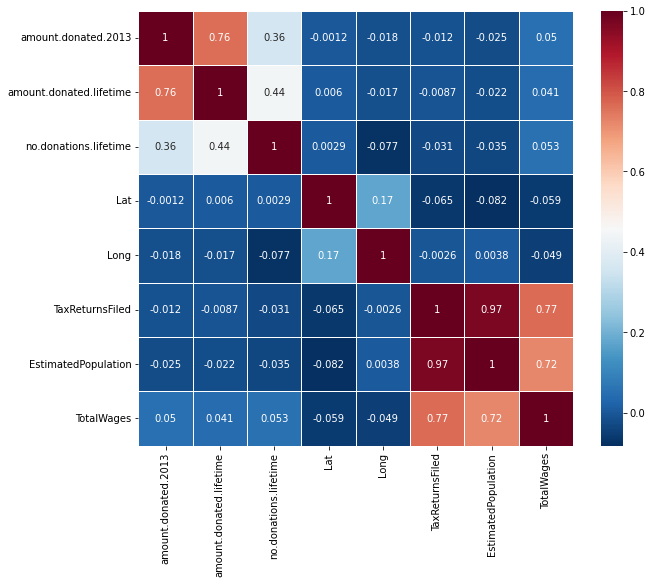

In [71]:
import seaborn as sns
plt.figure(figsize=(10,8))
cm = X_train.corr(method='pearson')
sns.heatmap(cm, annot=True, cmap = 'RdBu_r',linewidth=0.5,square=True)
plt.show()

In [72]:
X_train

,billing.zip.code,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,season_s,package,no.seats_s,location_s,section,...,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,94708,San Francisco,0.0,0.0,0,2012-2013,Full,nan,San Francisco,Undefined,...,SAN FRANCISCO,CA,PRIMARY,37.754607,-121.346867,NA-US-CA-SAN FRANCISCO,False,13703.723229,21865.946459,9.240114e+08
1,94708,San Francisco,0.0,0.0,0,2012-2013,Full,nan,San Francisco,Undefined,...,SAN FRANCISCO,CA,PRIMARY,37.754607,-121.346867,NA-US-CA-SAN FRANCISCO,False,13703.723229,21865.946459,9.240114e+08
2,94597,Walnut Creek,0.0,0.0,0,2012-2013,Full,nan,San Francisco,Undefined,...,WALNUT CREEK,CA,PRIMARY,37.910000,-122.070000,NA-US-CA-WALNUT CREEK,False,10755.000000,16977.000000,6.592431e+08
3,94005,Brisbane,0.0,0.0,0,2002-2003,Full,1.0,San Francisco,Undefined,...,BRISBANE,CA,PRIMARY,37.680000,-122.410000,NA-US-CA-BRISBANE,False,2641.000000,4345.000000,1.997331e+08
4,94610,Oakland,0.0,0.0,0,2012-2013,Full,nan,San Francisco,Undefined,...,OAKLAND,CA,PRIMARY,37.810000,-122.240000,NA-US-CA-OAKLAND,False,16601.000000,24162.000000,1.004840e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26168,94117,San Francisco,0.0,246.0,8,1996-1997,Full,2.0,Santa Rosa,Orchestra,...,SAN FRANCISCO,CA,PRIMARY,37.760000,-122.440000,NA-US-CA-SAN FRANCISCO,False,21795.000000,27878.000000,1.499767e+09
26169,94117,San Francisco,0.0,246.0,8,1995-1996,Full,2.0,Santa Rosa,Balcony,...,SAN FRANCISCO,CA,PRIMARY,37.760000,-122.440000,NA-US-CA-SAN FRANCISCO,False,21795.000000,27878.000000,1.499767e+09
26170,94117,San Francisco,0.0,246.0,8,1998-1999,Full,2.0,San Francisco,Dress Circle,...,SAN FRANCISCO,CA,PRIMARY,37.760000,-122.440000,NA-US-CA-SAN FRANCISCO,False,21795.000000,27878.000000,1.499767e+09
26171,94117,San Francisco,0.0,246.0,8,1999-2000,Full,2.0,San Francisco,Dress Circle,...,SAN FRANCISCO,CA,PRIMARY,37.760000,-122.440000,NA-US-CA-SAN FRANCISCO,False,21795.000000,27878.000000,1.499767e+09


In [73]:
# TO aovid too many columns encoded by the onehot encoder
onehot=[]
ordinal=[]
for col in cate:
    if len(X_train[col].unique()) > 20:
        ordinal.append(col)
    else:
        onehot.append(col)  

In [74]:
onehot

['package',
 'no.seats_s',
 'location_s',
 'section',
 'price.level_s',
 'subscription_tier',
 'multiple.subs',
 'ZipCodeType',
 'LocationType',
 'Decommisioned']

In [75]:
ordinal

['billing.zip.code',
 'billing.city',
 'season_s',
 'Zipcode',
 'City',
 'State',
 'Location']

## Encoding data

In [76]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
def ordinal_encode(X,cols):
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    # Fit the encoder on training data and transform it.  We can also use it to transform test data
    X[cols] = enc.fit_transform(X[cols])
    return X,enc

In [77]:
X_train_encoded = X_train.copy()
X_train_encoded,ordinal_enc = ordinal_encode(X_train_encoded,ordinal)
X_train_encoded.head()

,billing.zip.code,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,season_s,package,no.seats_s,location_s,section,...,City,State,LocationType,Lat,Long,Location,Decommisioned,TaxReturnsFiled,EstimatedPopulation,TotalWages
0,777.0,500.0,0.0,0.0,0,19.0,Full,nan,San Francisco,Undefined,...,415.0,3.0,PRIMARY,37.754607,-121.346867,229.0,False,13703.723229,21865.946459,9.240114e+08
1,777.0,500.0,0.0,0.0,0,19.0,Full,nan,San Francisco,Undefined,...,415.0,3.0,PRIMARY,37.754607,-121.346867,229.0,False,13703.723229,21865.946459,9.240114e+08
2,720.0,611.0,0.0,0.0,0,19.0,Full,nan,San Francisco,Undefined,...,507.0,3.0,PRIMARY,37.910000,-122.070000,281.0,False,10755.000000,16977.000000,6.592431e+08
3,514.0,77.0,0.0,0.0,0,9.0,Full,1.0,San Francisco,Undefined,...,58.0,3.0,PRIMARY,37.680000,-122.410000,40.0,False,2641.000000,4345.000000,1.997331e+08
4,738.0,385.0,0.0,0.0,0,19.0,Full,nan,San Francisco,Undefined,...,315.0,3.0,PRIMARY,37.810000,-122.240000,169.0,False,16601.000000,24162.000000,1.004840e+09


In [78]:
def onehot_encode(X,cols):
    # Treat new categories as a new 'unknown' category (all onehot columns are 0)
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[cols])
    # Get the names of the new columns created
    colnames = columns=list(onehot_enc.get_feature_names(input_features=cols))
    # Transform the data
    onehot_vals = onehot_enc.transform(X[cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(cols,axis=1)
    return X,onehot_enc


# Features to one-hot encode

X_train_encoded, onehot_enc = onehot_encode(X_train_encoded,onehot)

X_train_encoded.head()

,billing.zip.code,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,season_s,Zipcode,City,State,Lat,...,subscription_tier_8.0,subscription_tier_nan,multiple.subs_no,multiple.subs_yes,ZipCodeType_PO BOX,ZipCodeType_STANDARD,ZipCodeType_UNIQUE,LocationType_PRIMARY,Decommisioned_False,Decommisioned_True
0,777.0,500.0,0.0,0.0,0,19.0,633.0,415.0,3.0,37.754607,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,777.0,500.0,0.0,0.0,0,19.0,633.0,415.0,3.0,37.754607,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,720.0,611.0,0.0,0.0,0,19.0,605.0,507.0,3.0,37.910000,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,514.0,77.0,0.0,0.0,0,9.0,455.0,58.0,3.0,37.680000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,738.0,385.0,0.0,0.0,0,19.0,617.0,315.0,3.0,37.810000,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [79]:
def encode_test_set(X,ordinal_cols,onehot_cols,ordinal_encoder,onehot_encoder):

    
    # Apply ordinal encoder
    X[ordinal_cols] = ordinal_encoder.transform(X[ordinal_cols])
    
    # Apply onehot encoder
    colnames = columns=list(onehot_encoder.get_feature_names(input_features=onehot_cols))
    onehot_vals = onehot_encoder.transform(X[onehot_cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(onehot_cols,axis=1)
    
    return X

In [80]:
X_test=test
X_test_encoded = X_test.copy()
X_test_encoded = encode_test_set(X_test_encoded,ordinal,onehot,ordinal_enc,onehot_enc)
display(X_test_encoded.head())

,ID,billing.zip.code,billing.city,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,season_s,Zipcode,City,State,...,subscription_tier_8.0,subscription_tier_nan,multiple.subs_no,multiple.subs_yes,ZipCodeType_PO BOX,ZipCodeType_STANDARD,ZipCodeType_UNIQUE,LocationType_PRIMARY,Decommisioned_False,Decommisioned_True
0,001i000000NuQ6Y,585.0,500.0,0.0,1818.0,7,12.0,502.0,415.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,001i000000NuQ6Y,585.0,500.0,0.0,1818.0,7,17.0,502.0,415.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,001i000000NuQ6Y,585.0,500.0,0.0,1818.0,7,17.0,502.0,415.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,001i000000NuQ6Y,585.0,500.0,0.0,1818.0,7,17.0,502.0,415.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,001i000000NuQ6Y,585.0,500.0,0.0,1818.0,7,17.0,502.0,415.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [81]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26173 entries, 0 to 26172
Data columns (total 94 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   billing.zip.code              26173 non-null  float64
 1   billing.city                  26173 non-null  float64
 2   amount.donated.2013           26173 non-null  float64
 3   amount.donated.lifetime       26173 non-null  float64
 4   no.donations.lifetime         26173 non-null  int64  
 5   season_s                      26173 non-null  float64
 6   Zipcode                       26173 non-null  float64
 7   City                          26173 non-null  float64
 8   State                         26173 non-null  float64
 9   Lat                           26173 non-null  float64
 10  Long                          26173 non-null  float64
 11  Location                      26173 non-null  float64
 12  TaxReturnsFiled               26173 non-null  float64
 13  E

## Build models

In [82]:
from sklearn.model_selection import train_test_split
X_train_val,X_val,y_train_val,y_test_val = train_test_split(X_train_encoded,y_train,random_state=0,test_size=0.15)

In [83]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
model_a=DecisionTreeClassifier()
model_b=RandomForestClassifier()
model_c=AdaBoostClassifier()

In [84]:
from sklearn.metrics import roc_auc_score
model_a.fit(X_train_val,y_train_val)
preds_val=model_a.predict(X_val)
preds_pro=model_a.predict_proba(X_val)[:, 1]
roc_auc_score(y_test_val,preds_pro)

0.9898992331173018

In [85]:
model_b.fit(X_train_val,y_train_val)
preds_val=model_b.predict(X_val)
preds_pro=model_b.predict_proba(X_val)
preds_pro=model_b.predict_proba(X_val)[:, 1]
roc_auc_score(y_test_val,preds_pro)

0.9979126236422688

In [86]:
model_c.fit(X_train_val,y_train_val)
preds_val=model_c.predict(X_val)
preds_pro=model_c.predict_proba(X_val)
preds_pro=model_c.predict_proba(X_val)[:, 1]
roc_auc_score(y_test_val,preds_pro)

0.9511740647148627

As we can see, the model perform best when using the Randomforest Classifier.

## Tuning models for Randomforest Classifier

### 1)Max_depth

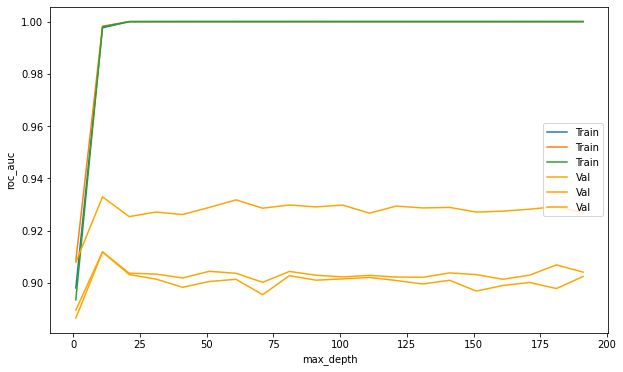

In [87]:
from sklearn.model_selection import validation_curve
train_score, val_score=validation_curve(estimator=RandomForestClassifier(), X=X_train_encoded, y=y_train, param_name='max_depth', param_range=np.arange(1,200,10), cv=3, scoring='roc_auc')
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,200,10),train_score,label='Train')
plt.plot(np.arange(1,200,10),val_score,color='orange',label='Val')
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

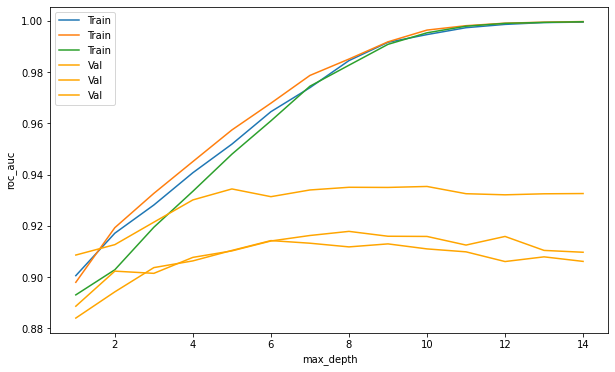

In [88]:
from sklearn.model_selection import validation_curve
train_score, val_score=validation_curve(estimator=RandomForestClassifier(), X=X_train_encoded, y=y_train, param_name='max_depth', param_range=np.arange(1,15,1), cv=3, scoring='roc_auc')
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,15,1),train_score,label='Train')
plt.plot(np.arange(1,15,1),val_score,color='orange',label='Val')
plt.xlabel('max_depth')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

### 2)n_estimators

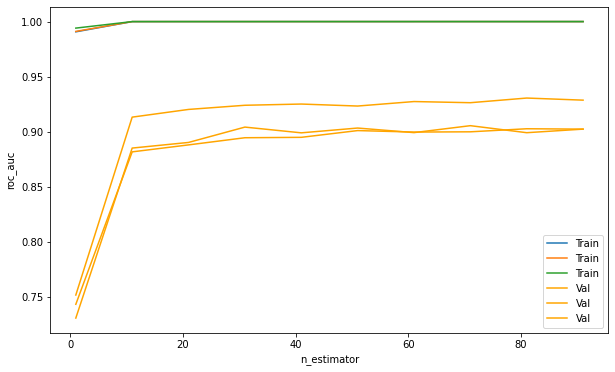

In [89]:
from sklearn.model_selection import validation_curve
train_score, val_score=validation_curve(estimator=RandomForestClassifier(), X=X_train_encoded, y=y_train, param_name='n_estimators', param_range=np.arange(1,100,10), cv=3, scoring='roc_auc')
plt.figure(figsize=(10,6))
plt.plot(np.arange(1,100,10),train_score,label='Train')
plt.plot(np.arange(1,100,10),val_score,color='orange',label='Val')
plt.xlabel('n_estimator')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

### 3)min_samples_split

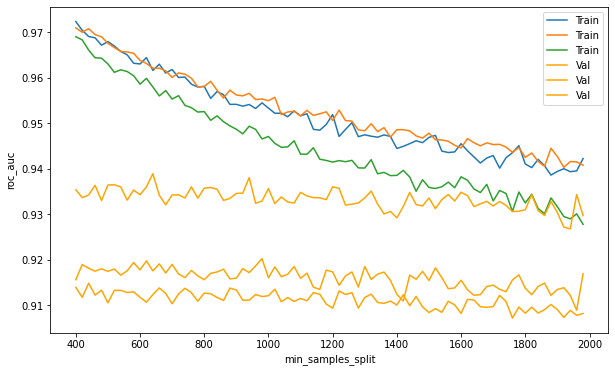

In [90]:
from sklearn.model_selection import validation_curve
train_score, val_score=validation_curve(estimator=RandomForestClassifier(), X=X_train_encoded, y=y_train, param_name='min_samples_split', param_range=np.arange(400,2000,20), cv=3, scoring='roc_auc')
plt.figure(figsize=(10,6))
plt.plot(np.arange(400,2000,20),train_score,label='Train')
plt.plot(np.arange(400,2000,20),val_score,color='orange',label='Val')
plt.xlabel('min_samples_split')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

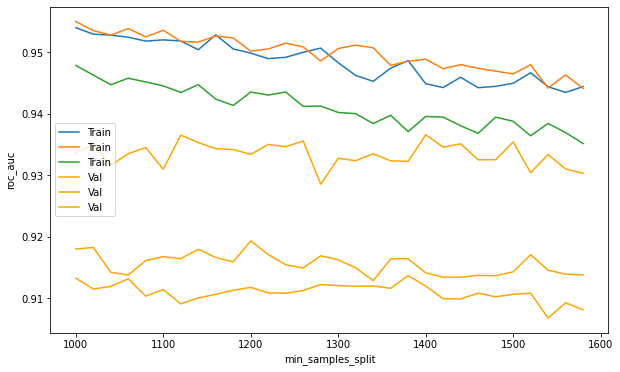

In [91]:
from sklearn.model_selection import validation_curve
train_score, val_score=validation_curve(estimator=RandomForestClassifier(), X=X_train_encoded, y=y_train, param_name='min_samples_split', param_range=np.arange(1000,1600,20), cv=3, scoring='roc_auc')
plt.figure(figsize=(10,6))
plt.plot(np.arange(1000,1600,20),train_score,label='Train')
plt.plot(np.arange(1000,1600,20),val_score,color='orange',label='Val')
plt.xlabel('min_samples_split')
plt.ylabel('roc_auc')
plt.legend()
plt.show()

## Using Grid Search to find the optimal combinations of all hyperparameters

In [104]:
param_grid = { 
    'n_estimators': [15,20,25],
    'max_depth' : [5,6,7,8,9],
    'min_samples_split':[800,1000]
    
}

In [105]:
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 3, scoring='roc_auc')
CV_rfc.fit(X_train_val,y_train_val)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'min_samples_split': [800, 1000],
                         'n_estimators': [15, 20, 25]},
             scoring='roc_auc')

In [106]:
CV_rfc.best_params_

{'max_depth': 9, 'min_samples_split': 800, 'n_estimators': 25}

### Test the result in validation set

In [108]:
best_model=RandomForestClassifier(max_depth=9,min_samples_split=800,n_estimators=25)
model_b.fit(X_train_val,y_train_val)
preds_val=model_b.predict(X_val)
preds_pro=model_b.predict_proba(X_val)
preds_pro=model_b.predict_proba(X_val)[:, 1]
roc_auc_score(y_test_val,preds_pro)

0.9433525990398407

In [95]:
X_test_noid=X_test_encoded.drop('ID',axis=1)

In [107]:

model_b.fit(X_train_encoded,y_train)
preds=model_b.predict(X_test_noid)
preds_pro=model_b.predict_proba(X_test_noid)[:, 1]


In [97]:
final=pd.DataFrame(X_test["ID"])

In [98]:
final['Predicted']=preds_pro

In [99]:
final['Predicted']=pd.Series(preds_pro)

In [100]:
final

,ID,Predicted
0,001i000000NuQ6Y,0.254201
1,001i000000NuQ6Y,0.470400
2,001i000000NuQ6Y,0.470400
3,001i000000NuQ6Y,0.470400
4,001i000000NuQ6Y,0.470400
...,...,...
11239,001i000000NuRJd,0.021254
11240,001i000000NuRJd,0.021254
11241,001i000000NuRJd,0.021254
11242,001i000000NuRJd,0.021254


In [101]:
sub=final.groupby('ID')['Predicted'].mean()

In [102]:
sub=pd.DataFrame(sub)
sub.head()

,Predicted
ID,
001i000000LhyPF,0.924788
001i000000LhyPG,0.743286
001i000000LhyPP,0.751632
001i000000LhyPb,0.683796
001i000000LhyPg,0.833416


In [103]:
sub.to_csv('final_3.csv')
